In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import warnings
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA
import lightgbm as lgb

sns.set()
warnings.filterwarnings('ignore')

In [41]:
train_logs = pd.read_csv('input/train_logs.csv')
train_scores = pd.read_csv('input/train_scores.csv')
essays_texts = pd.read_csv('output/essays.csv')

In [72]:
essays = pd.DataFrame()
essays['id'] = train_scores['id']
essays['score'] = train_scores['score']
g = train_logs.groupby(['id'])['event_id'].agg('count')
essays['total_events'] = g.values

events = [',', '-', '.', '(', 'Leftclick', 'CapsLock', '"', '?', "'", '\\', 'Enter']
g = train_logs.groupby(['id', 'down_event']).count().unstack(fill_value=0).stack()
for event in events:
    essays[event + '_freq'] =  g[g.index.get_level_values('down_event') == event]['event_id'].values / essays['total_events']

activities = ['Replace']
g = train_logs.groupby(['id', 'activity']).count().unstack(fill_value=0).stack()
for activity in activities:
    essays[activity + '_freq'] =  g[g.index.get_level_values('activity') == activity]['event_id'].values / essays['total_events']

cpos = [0, 1, 4, 10, 15, 20, 50, 100, 200, 500, 1000]
g = train_logs.groupby(['id', 'cursor_position']).count().unstack(fill_value=0).stack()
for pos in cpos:
    essays[str(pos) + '_freq'] =  g[g.index.get_level_values('cursor_position') == pos]['event_id'].values / essays['total_events']

g = train_logs.groupby(['id']).nth([-1])['word_count']
essays['word_count'] = g.values
essays.head()

,id,score,total_events,",_freq",-_freq,._freq,(_freq,Leftclick_freq,CapsLock_freq,"""_freq",...,4_freq,10_freq,15_freq,20_freq,50_freq,100_freq,200_freq,500_freq,1000_freq,word_count
0,001519c8,3.5,2557,0.004693,0.000000,0.008213,0.0,0.035980,0.000000,0.000000,...,0.000782,0.000782,0.001173,0.001173,0.000782,0.000391,0.000782,0.000391,0.000391,255
1,0022f953,3.5,2454,0.008557,0.002037,0.006112,0.0,0.022820,0.000000,0.002445,...,0.000407,0.001222,0.001222,0.001222,0.000407,0.001222,0.000407,0.001630,0.000815,320
2,0042269b,6.0,4136,0.005561,0.000242,0.005077,0.0,0.031190,0.000000,0.000484,...,0.000484,0.000484,0.000725,0.000725,0.001209,0.001209,0.000725,0.000725,0.000484,404
3,0059420b,2.0,1556,0.001928,0.000000,0.008355,0.0,0.011568,0.001285,0.000000,...,0.000643,0.000643,0.000643,0.001285,0.000643,0.001285,0.000643,0.000643,0.000643,206
4,0075873a,4.0,2531,0.009482,0.000000,0.009087,0.0,0.013038,0.000000,0.000000,...,0.000395,0.000395,0.000395,0.000395,0.000395,0.000790,0.000790,0.000395,0.000395,252


In [73]:
essays2 = essays.copy()
train_logs2 = train_logs.copy()
train_logs2['interval'] = train_logs['down_time'].diff()
g = train_logs2.groupby(['id']).apply(lambda group: group.iloc[1:, 1:])['interval']
essays2['max_pause'] = g.groupby('id').agg('max').values
pause_thresholds = [1000, 50000]
for p in pause_thresholds:
    col = str(p) + 'ms_pauses'
    g = train_logs2[train_logs2['interval'] > p].groupby('id')['event_id'].count()
    g_df = pd.DataFrame()
    g_df['id'] = g.index
    g_df['pauses'] = g.values
    df = pd.merge(train_logs2, g_df, how='left', left_on='id', right_on='id').fillna(0)
    essays2[col] = df.groupby('id')['pauses'].agg('max').values / essays2['total_events']

In [61]:
et2 = essays_texts.copy()
et2.head(2)
def extract_essay_info(row):
    essay = row['essay']
    n_paragraphs = 0
    n_sentences = 0
    n_words = 0
    n_characters = 0
    for p in essay.split('\n'):
        if re.match(r'.*\w+', p):
            n_paragraphs += 1
            for s in p.split('.'):
                if re.match(r'.*\w+', s):
                    n_sentences += 1
                    for w in s.split():
                        if re.match(r'.*\w+', w):
                            n_words += 1
                            n_characters += len(w)
    row['n_sentences_per_p'] = n_sentences / n_paragraphs
    row['n_chars_per_s'] = n_characters / n_sentences
    row['avg_word_length'] = n_characters / n_words
    return row
et2 = et2.apply(extract_essay_info, axis=1)
et2.head(2)

,Unnamed: 0,id,score,essay,n_sentences_per_p,n_chars_per_s,avg_word_length
0,0,001519c8,3.5,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...,5.000000,83.066667,4.867188
1,1,0022f953,3.5,"qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq...",2.166667,100.307692,4.075000


In [76]:
essays2['n_sentences_per_p'] = et2['n_sentences_per_p']
essays2['n_chars_per_s'] = et2['n_chars_per_s']
essays2['avg_word_length'] = et2['avg_word_length']

In [77]:
freqs = [str(e) + '_freq' for e in events + activities + cpos]
pauses = [str(p) + 'ms_pauses' for p in pause_thresholds]
words = ['avg_word_length', 'n_sentences_per_p']
others = ['word_count', 'max_pause']
data_cols = freqs + pauses + words + others

data = pd.DataFrame()
data['features'] = data_cols
data['VIF'] = [variance_inflation_factor(essays2[data_cols], i).round(1) for i in range(essays2[data_cols].shape[1])]
f_scores, p_scores = f_regression(essays2[data_cols], essays2['score'])
data['Fscores'] = f_scores.round(0)
data['Pscores'] = p_scores.round(5)
data = data.sort_values(by='Fscores', ascending=False)
data

,features,VIF,Fscores,Pscores
27,word_count,12.3,1715.0,0.00000
23,1000ms_pauses,6.9,974.0,0.00000
24,50000ms_pauses,2.5,471.0,0.00000
0,",_freq",5.2,467.0,0.00000
17,20_freq,4.6,258.0,0.00000
15,10_freq,5.1,253.0,0.00000
13,1_freq,3.0,243.0,0.00000
25,avg_word_length,37.0,193.0,0.00000
22,1000_freq,2.5,176.0,0.00000
1,-_freq,1.5,153.0,0.00000


In [78]:
X, y = essays2[data_cols], essays2['score']
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', str(ord(x[0])), x))
X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(X, y, test_size=.2, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_and_valid, y_train_and_valid, test_size=.25, random_state=20)

In [79]:
def round_scores(scores):
    scores = ((scores * 2) // 1) * .5
    scores = np.where(scores < 0, 0.0, scores)
    scores = np.where(scores > 6, 6.0, scores)
    return scores

MAE: training set
0.6346920576918905
MAE: validation set
0.7120990241833751


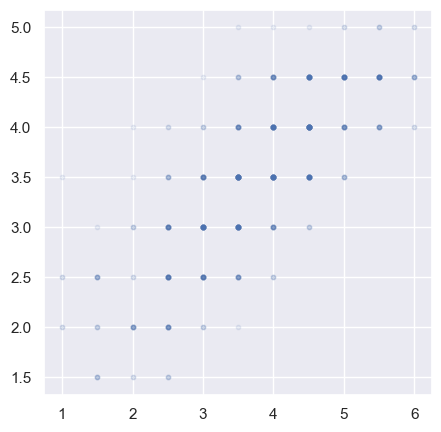

In [80]:
model = GradientBoostingRegressor(max_depth=2, min_samples_leaf=4, n_estimators=50, learning_rate=.1, subsample=.5)
model.fit(X_train, y_train)
y_predict_train = round_scores(model.predict(X_train))
y_predict_valid = round_scores(model.predict(X_valid))
print('MAE: training set')
print(mean_squared_error(y_train, y_predict_train, squared=False))
print('MAE: validation set')
print(mean_squared_error(y_valid, y_predict_valid, squared=False))
plt.figure(figsize=(5,5))
plt.scatter(y_valid, y_predict_valid, s=10, alpha=.1);